In [2]:
import xs

In [1]:
import numpy as np
from scipy.integrate import odeint
from math import isclose
import graph
import matplotlib.pyplot as plt
import timeit
import imp

In [3]:
imp.reload(graph)

<module 'graph' from 'C:\\Users\\GUNU\\Dropbox\\SNUPI\\Python_Projects\\Global_Model\\Working\\graph.py'>

ion, neutral 들은 0.05eV로 고정

In [18]:
kB = 1.38e-23 #[J/K] [m2 kg K-1 s-2] Boltzmann constant
e = 1.602e-19 #[C] electronic charge
M = 1.67e-27 #[kg] mass of H atom
m = 9.1e-31 #[kg] mass of electorn

# ro = 100e-3 #[m] radius of chamber
# l = 312e-3 #[m] chamber length
# ro_min = 25e-3 
# l_min = 200e-3
# a_cf = 0.33 #magnetic confinement parameter (0~1) if 1, B-field is absent.

ro = 100e-3 #[m]
l = 400e-3 #[m]
a_cf = 1

Tg = 300 #[K] room temperature
sigma_i = 5e-19 #[m2]
rec = 0.1 #Recombination Factor
V = np.pi*ro**2*l #[m^3] discharge volume
v0 = (8*Tg*kB/(M*np.pi))**0.5 #[m/s] mean velocity of H atom
LAMBDAeff = ((2.405/ro)**2+(np.pi/l)**2)**-0.5 #[m]
D_Kn = v0 * LAMBDAeff/3 #[m2/s]
Deff = D_Kn
T1 = LAMBDAeff**2/Deff #[s]

In [19]:
class Model:
    def __init__(self, p, input_power, duty, period, time_resolution=1e-8):
        self.p = p
        self.input_power = input_power*6.241509e18 # [J/s] to [eV/s]
        self.duty = duty
        self.period = period 
        self.time_resolution = time_resolution

        self.ng = (p/7.5)/(Tg*kB) #[m^-3]
        lambda_i = 1/(self.ng*sigma_i) #[m] ion-neutral mean free path
        hl = 0.86*(3+l/2/lambda_i)**-0.5
        hR = 0.8*(4+ro/lambda_i)**-0.5
        
        self.Aeff = 2*np.pi*ro*(a_cf*l*hR+ro*hl)  #[m^2] effective area
        
        #self.Aeff = 2*np.pi*ro*(a_cf*l*hR+ro*hl)+2*np.pi*ro_min*l_min*hR  #[m^2] effective area
        
        self.rec = 0.1 # recombination factor
        self.routine_time_interval = np.linspace(0, self.period, int(self.period/self.time_resolution))
        print('Condition : {}mTorr, {}W, {}ms, {}'.format(self.p, self.input_power/6.241509e18, self.period*1000, self.duty))
        
    def balance_equations(self,calculation_array, t, power):
        Te, nH, nH_2s, nH2_v1, nH2_v2, nH2_v3, nH2_v4, nH2_v5, nH2_v6, nH2_v7, nH2_v8, nH2_v9, nHp, nH2p, nH3p, nHm = calculation_array
        
        
        
        #Quasi-Neutrality eqn 완료
        ne = nHp + nH2p + nH3p - nHm
        
        #Hydrogen atom conservation eqn 완료
        nH2_v0 = self.ng - (0.5*(nH + nHp + nH_2s + nHm) + sum(calculation_array[3:12]) + nH2p + 1.5*nH3p)
        
        uB = np.sqrt(e*Te/M) #[m/s]
        uB2 = np.sqrt(e*Te/2/M)
        uB3 = np.sqrt(e*Te/3/M)
        Vs = -Te*np.log(4/ne/np.sqrt(8*e*Te/np.pi/m)*(nHp*uB+nH2p*uB2+nH3p*uB3))
        #print('complex Vs: ',Vs)
        #Vs = Te*np.log(np.sqrt(M/(2*np.pi*m)))
        #print('simple Vs: ',Vs)
        t0 = V/self.Aeff*np.sqrt(M/(e*Te)) #[s] Characteristic transit time of H+ ion 
        
        ##### Rate coefficient calculation ##### 전부 m3/s로
        k1_0 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction1_0')
        k1_1 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction1_1')
        k1_2 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction1_2')
        k1_3 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction1_3')
        k1_4 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction1_4')
        k2 = np.exp(-2.858072836568e+01+1.038543976082e+01*np.log(Te)-5.383825026583e+00*(np.log(Te))**2+1.950636494405e+00*(np.log(Te))**3-5.393666392407e-01*(np.log(Te))**4+1.006916814453e-01*(np.log(Te))**5-1.160758573972e-02*(np.log(Te))**6+7.411623859122e-04*(np.log(Te))**7-2.001369618807e-05*(np.log(Te))**8)*1e-6
        k3_1 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction3_1')
        k3_2 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction3_2')
        k3_3 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction3_3')
        k3_4 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction3_4')
        k3_5 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction3_5')
        k3_6 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction3_6')
        k4_0 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_0')
        k4_1 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_1')
        k4_2 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_2')
        k4_3 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_3')
        k4_4 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_4')
        k4_5 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_5')
        k4_6 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_6')
        k4_7 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_7')
        k4_8 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction4_8')
        k5_0 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_0')
        k5_1 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_1')
        k5_2 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_2')
        k5_3 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_3')
        k5_4 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_4')
        k5_5 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_5')
        k5_6 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_6')
        k5_7 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_7')
        k5_8 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_8')
        k5_9 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction5_9')
        k6_0 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_0')
        k6_1 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_1')
        k6_2 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_2')
        k6_3 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_2') #xs 데이터 보완 必
        k6_4 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_5') #xs 데이터 보완 必
        k6_5 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_5')
        k6_6 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_6')
        k6_7 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_7')
        k6_8 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_8')
        k6_9 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction6_9')
        k7 = np.exp(-3.834597006782e+01+1.426322356722e+01*np.log(Te)-5.826468569506e+00*(np.log(Te))**2+1.727940947913e+00*(np.log(Te))**3-3.598120866343e-01*(np.log(Te))**4+4.822199350494e-02*(np.log(Te))**5-3.909402993006e-03*(np.log(Te))**6+1.738776657690e-04*(np.log(Te))**7-3.252844486351e-06*(np.log(Te))**8)*1e-6
        k8 = np.exp(-3.271396786375e+01+1.353655609057e+01*np.log(Te)-5.739328757388e+00*(np.log(Te))**2+1.563154982022e+00*(np.log(Te))**3-2.877056004391e-01*(np.log(Te))**4+3.482559773737e-02*(np.log(Te))**5-2.631976175590e-03*(np.log(Te))**6+1.119543953861e-04*(np.log(Te))**7-2.039149852002e-06*(np.log(Te))**8)*1e-6
        k9 = np.exp(-1.781416067709e+01+2.277799785711e+00*np.log(Te)-1.266868411626e+00*(np.log(Te))**2+4.296170447419e-01*(np.log(Te))**3-9.609908013189e-02*(np.log(Te))**4+1.387958040699e-02*(np.log(Te))**5-1.231349039470e-03*(np.log(Te))**6+6.042383126281e-05*(np.log(Te))**7-1.247521040900e-06*(np.log(Te))**8)*1e-6
        k10 = 2.11e-9*1e-6
        k11 = np.exp(-1.700270758355e+01-4.050073042947e-01*np.log(Te)+1.018733477232e-08*(np.log(Te))**2-1.695586285687e-08*(np.log(Te))**3+1.564311217508e-10*(np.log(Te))**4+1.979725412288e-09*(np.log(Te))**5-4.395545994733e-10*(np.log(Te))**6+3.584926377078e-11*(np.log(Te))**7-1.024189019465e-12*(np.log(Te))**8)*1e-6
        k12 = np.exp(-3.078408636631e+01+1.509421488513e+01*np.log(Te)-7.349167207324e+00*(np.log(Te))**2+2.320966107642e+00*(np.log(Te))**3-4.818077551719e-01*(np.log(Te))**4+6.389229162737e-02*(np.log(Te))**5-5.161880953089e-03*(np.log(Te))**6+2.303985092606e-04*(np.log(Te))**7-4.344846146197e-06*(np.log(Te))**8)*1e-6
        k13 = xs.quick_rate_constant_with_analytic_xs(Te, 'reaction13')
        k14 = np.exp(-1.801849334273e+01+2.360852208681e+00*np.log(Te)-2.827443061704e-01*(np.log(Te))**2+1.623316639567e-02*(np.log(Te))**3-3.365012031363e-02*(np.log(Te))**4+1.178329782711e-02*(np.log(Te))**5-1.656194699504e-03*(np.log(Te))**6+1.068275202678e-04*(np.log(Te))**7-2.631285809207e-06*(np.log(Te))**8)*1e-6
        k15 = 3e-10*1e-6 # Janev
        k16 = 9e-14 #3e-10*1e-6 #ion 0.1eV 
        k17 = 7e-13 #3e-10*1e-6 # at ion Janev 94page
        k18 = 7e-13 #3e-10*1e-6 # Assumption
        k19 = np.exp(-3.454175591367e+01+1.412655911280e+01*np.log(Te)-6.004466156761e+00*(np.log(Te))**2+1.589476697488e+00*(np.log(Te))**3-2.775796909649e-01*(np.log(Te))**4+3.152736888124e-02*(np.log(Te))**5-2.229578042005e-03*(np.log(Te))**6+8.890114963166e-05*(np.log(Te))**7-1.523912962346e-06*(np.log(Te))**8)*1e-6
        k20 = np.exp(-2.833259375256e+01+9.587356325603e+00*np.log(Te)-4.833579851041e+00*(np.log(Te))**2+1.415863373520e+00*(np.log(Te))**3-2.537887918825e-01*(np.log(Te))**4+2.800713977946e-02*(np.log(Te))**5-1.871408172571e-03*(np.log(Te))**6+6.986668318407e-05*(np.log(Te))**7-1.123758504195e-06*(np.log(Te))**8)*1e-6
        k21 = np.exp(-1.973476726029e+01+3.992702671457e+00*np.log(Te)-1.773436308973e+00*(np.log(Te))**2+5.331949621358e-01*(np.log(Te))**3-1.181042453190e-01*(np.log(Te))**4+1.763136575032e-02*(np.log(Te))**5-1.616005335321e-03*(np.log(Te))**6+8.093908992682e-05*(np.log(Te))**7-1.686664454913e-06*(np.log(Te))**8)*1e-6
        k22_1_0 = 0.42e-13*1e-6 #non-reactive assumption
        k22_2_0 = 0.59e-12*1e-6
        k22_2_1 = 0.30e-12*1e-6
        k22_3_0 = 0.15e-11*1e-6
        k22_3_1 = 0.16e-11*1e-6
        k22_3_2 = 0.20e-11*1e-6
        k22_4_0 = 0.43e-11*1e-6
        k22_4_1 = 0.42e-11*1e-6
        k22_4_2 = 0.49e-11*1e-6
        k22_4_3 = 0.55e-11*1e-6
        k22_5_0 = 0.16e-11*1e-6
        k22_5_1 = 0.37e-11*1e-6
        k22_5_2 = 0.69e-11*1e-6
        k22_5_3 = 0.74e-11*1e-6
        k22_5_4 = 0.89e-11*1e-6
        k22_6_0 = 0.33e-11*1e-6
        k22_6_1 = 0.51e-11*1e-6
        k22_6_2 = 0.53e-11*1e-6
        k22_6_3 = 0.69e-11*1e-6
        k22_6_4 = 0.11e-10*1e-6
        k22_6_5 = 0.12e-10*1e-6
        k22_7_0 = 0.24e-11*1e-6
        k22_7_1 = 0.38e-11*1e-6
        k22_7_2 = 0.68e-11*1e-6
        k22_7_3 = 0.57e-11*1e-6
        k22_7_4 = 0.70e-11*1e-6
        k22_7_5 = 0.11e-10*1e-6
        k22_7_6 = 0.12e-10*1e-6
        k22_8_0 = 0.30e-11*1e-6
        k22_8_1 = 0.29e-11*1e-6
        k22_8_2 = 0.29e-11*1e-6
        k22_8_3 = 0.35e-11*1e-6
        k22_8_4 = 0.56e-11*1e-6
        k22_8_5 = 0.82e-11*1e-6
        k22_8_6 = 0.12e-10*1e-6
        k22_8_7 = 0.14e-10*1e-6
        k22_9_0 = 0.52e-12*1e-6
        k22_9_1 = 0.14e-11*1e-6
        k22_9_2 = 0.30e-11*1e-6
        k22_9_3 = 0.37e-11*1e-6
        k22_9_4 = 0.48e-11*1e-6
        k22_9_5 = 0.53e-11*1e-6
        k22_9_6 = 0.92e-11*1e-6
        k22_9_7 = 0.13e-10*1e-6
        k22_9_8 = 0.14e-10*1e-6
        k23 = rec*Deff/LAMBDAeff**2
        k24 = uB*self.Aeff/V
        k25 = uB2*self.Aeff/V
        k26 = uB3*self.Aeff/V
        k27 = Deff/LAMBDAeff**2
        k28_1_0 = 1*Deff/LAMBDAeff**2
        k28_2_0 = 0.6535*Deff/LAMBDAeff**2
        k28_2_1 = 0.35*Deff/LAMBDAeff**2
        k28_3_0 = 0.30023*Deff/LAMBDAeff**2
        k28_3_1 = 0.40221*Deff/LAMBDAeff**2
        k28_3_2 = 0.30023*Deff/LAMBDAeff**2
        k28_4_0 = 0.17949*Deff/LAMBDAeff**2
        k28_4_1 = 0.25373*Deff/LAMBDAeff**2
        k28_4_2 = 0.32389*Deff/LAMBDAeff**2
        k28_4_3 = 0.24312*Deff/LAMBDAeff**2
        k28_5_0 = 0.15093*Deff/LAMBDAeff**2
        k28_5_1 = 0.17867*Deff/LAMBDAeff**2
        k28_5_2 = 0.22844*Deff/LAMBDAeff**2
        k28_5_3 = 0.23986*Deff/LAMBDAeff**2
        k28_5_4 = 0.19662*Deff/LAMBDAeff**2
        k28_6_0 = 0.12483*Deff/LAMBDAeff**2
        k28_6_1 = 0.13462*Deff/LAMBDAeff**2
        k28_6_2 = 0.16399*Deff/LAMBDAeff**2
        k28_6_3 = 0.1958*Deff/LAMBDAeff**2
        k28_6_4 = 0.20478*Deff/LAMBDAeff**2
        k28_6_5 = 0.17541*Deff/LAMBDAeff**2
        k28_7_0 = 0.10035*Deff/LAMBDAeff**2
        k28_7_1 = 0.11096*Deff/LAMBDAeff**2
        k28_7_2 = 0.13054*Deff/LAMBDAeff**2
        k28_7_3 = 0.15991*Deff/LAMBDAeff**2
        k28_7_4 = 0.17949*Deff/LAMBDAeff**2
        k28_7_5 = 0.17051*Deff/LAMBDAeff**2
        k28_7_6 = 0.15093*Deff/LAMBDAeff**2
        k28_8_0 = 0.08648*Deff/LAMBDAeff**2
        k28_8_1 = 0.09056*Deff/LAMBDAeff**2
        k28_8_2 = 0.10688*Deff/LAMBDAeff**2
        k28_8_3 = 0.12483*Deff/LAMBDAeff**2
        k28_8_4 = 0.16888*Deff/LAMBDAeff**2
        k28_8_5 = 0.15991*Deff/LAMBDAeff**2
        k28_8_6 = 0.14033*Deff/LAMBDAeff**2
        k28_8_7 = 0.12564*Deff/LAMBDAeff**2
        k28_9_0 = 0.07506*Deff/LAMBDAeff**2
        k28_9_1 = 0.07832*Deff/LAMBDAeff**2
        k28_9_2 = 0.08974*Deff/LAMBDAeff**2
        k28_9_3 = 0.11014*Deff/LAMBDAeff**2
        k28_9_4 = 0.13951*Deff/LAMBDAeff**2
        k28_9_5 = 0.14359*Deff/LAMBDAeff**2
        k28_9_6 = 0.12483*Deff/LAMBDAeff**2
        k28_9_7 = 0.12238*Deff/LAMBDAeff**2
        k28_9_8 = 0.11503*Deff/LAMBDAeff**2

        ##### Energy Loss per Reaction #####
        E1_0 = 15.42
        E1_1 = 15.42
        E1_2 = 15.42
        E1_3 = 15.42
        E1_4 = 15.42
        E2 = 8.5
        E3_1 = 0.5 
        E3_2 = 1 # Assumption (E3_2 = E3_1*2)
        E3_3 = 1.5
        E3_4 = 2
        E3_5 = 2.5
        E3_6 = 3
        E4_0 = 0.5
        E4_1 = 0.5
        E4_2 = 0.5
        E4_3 = 0.5
        E4_4 = 0.5
        E4_5 = 0.5
        E4_6 = 0.5
        E4_7 = 0.5
        E4_8 = 0.5
        E5_0 = Te
        E5_1 = Te
        E5_2 = Te
        E5_3 = Te
        E5_4 = Te
        E5_5 = Te
        E5_6 = Te
        E5_7 = Te
        E5_8 = Te
        E5_9 = Te
        E6_0 = 20 # XS데이터가 다 20부터 시작임
        E6_1 = 20
        E6_2 = 20
        E6_3 = 20
        E6_4 = 20
        E6_5 = 20
        E6_6 = 20
        E6_7 = 20
        E6_8 = 20
        E6_9 = 20
        E7 = 18
        E8 = 13.6
        E9 = 10.5
        E11 = Te
        E12 = 14
        E13 = Te
        E14 = 0.75
        E19 = 15.3 
        E20 = 10.2
        E21 = 3.4



        #Particle balance eqn for electron 완료
        dne_dt = (k1_0*ne*nH2_v0) + (k1_1*ne*nH2_v1) + (k1_2*ne*nH2_v2) + (k1_3*ne*nH2_v3) + (k1_4*ne*nH2_v4) - (k5_0*ne*nH2_v0) - (k5_1*ne*nH2_v1) - (k5_2*ne*nH2_v2) - (k5_3*ne*nH2_v3) - (k5_4*ne*nH2_v4) - (k5_5*ne*nH2_v5) - (k5_6*ne*nH2_v6) - (k5_7*ne*nH2_v7) - (k5_8*ne*nH2_v8) - (k5_9*ne*nH2_v9) + (k7*ne*nH2_v0) + (k8*ne*nH) - (k11*ne*nH3p) - (k13*ne*nH3p) + (k14*ne*nHm) + (k15*nH*nHm) + (k21*ne*nH_2s) - ne*uB*self.Aeff/V
        
#         print('-----------------------------------------')
#         print('ne: ', ne)
#         print('dne_dt: ',dne_dt)
#         print('k1(production): ',(k1_0*ne*nH2_v0) + (k1_1*ne*nH2_v1) + (k1_2*ne*nH2_v2) + (k1_3*ne*nH2_v3) + (k1_4*ne*nH2_v4))
#         print('k5(loss): ', - (k5_0*ne*nH2_v0) - (k5_1*ne*nH2_v1) - (k5_2*ne*nH2_v2) - (k5_3*ne*nH2_v3) - (k5_4*ne*nH2_v4) - (k5_5*ne*nH2_v5) - (k5_6*ne*nH2_v6) - (k5_7*ne*nH2_v7) - (k5_8*ne*nH2_v8) - (k5_9*ne*nH2_v9))
#         print('k7(production): ', (k7*ne*nH2_v0))
#         print('k8(production): ', (k8*ne*nH))
#         print('k11(loss): ', - (k11*ne*nH3p))
#         print('k13(loss): ', - (k13*ne*nH3p))
#         print('k14(production): ',(k14*ne*nHm) )
#         print('k15(production): ', (k15*nH*nHm))
#         print('k21(production): ', (k21*ne*nH_2s))
#         print('Wall(loss): ', - ne*uB*self.Aeff/V)
#         print('-----------------------------------------')
   
        #Power balance eqn for electron 완료
        dTe_dt = 2/(3*ne)*(self.pulse_power(t)/V - (Vs+2.5*Te)*ne*uB*self.Aeff/V - 3/2*Te*dne_dt - 3/2*((E1_0*k1_0*ne*nH2_v0) + (E1_1*k1_1*ne*nH2_v1) + (E1_2*k1_2*ne*nH2_v2) + (E1_3*k1_3*ne*nH2_v3) + (E1_4*k1_4*ne*nH2_v4) + (E2*k2*ne*nH2_v0) + (E3_1*k3_1*ne*nH2_v0) + (E3_2*k3_2*ne*nH2_v0) + (E3_3*k3_3*ne*nH2_v0) + (E3_4*k3_4*ne*nH2_v0) + (E3_5*k3_5*ne*nH2_v0) + (E3_6*k3_6*ne*nH2_v0) + (E4_1*k4_1*ne*nH2_v1) + (E4_2*k4_2*ne*nH2_v2) + (E4_3*k4_3*ne*nH2_v3) + (E4_4*k4_4*ne*nH2_v4) + (E4_5*k4_5*ne*nH2_v5) + (E4_6*k4_6*ne*nH2_v6) + (E4_7*k4_7*ne*nH2_v7) + (E4_8*k4_8*ne*nH2_v8) + (E5_0*k5_0*ne*nH2_v0) + (E5_1*k5_1*ne*nH2_v1) + (E5_2*k5_2*ne*nH2_v2) + (E5_3*k5_3*ne*nH2_v3) + (E5_4*k5_4*ne*nH2_v4) + (E5_5*k5_5*ne*nH2_v5) + (E5_6*k5_6*ne*nH2_v6) + (E5_7*k5_7*ne*nH2_v7) + (E5_8*k5_8*ne*nH2_v8) + (E5_9*k5_9*ne*nH2_v9) + (E6_0*k6_0*ne*nH2_v0) + (E6_1*k6_1*ne*nH2_v0) + (E6_2*k6_2*ne*nH2_v0) + (E6_3*k6_3*ne*nH2_v0) + (E6_4*k6_4*ne*nH2_v0) + (E6_5*k6_5*ne*nH2_v0) + (E6_6*k6_6*ne*nH2_v0) + (E6_7*k6_7*ne*nH2_v0) + (E6_8*k6_8*ne*nH2_v0) + (E6_9*k6_9*ne*nH2_v0) + (E7*k7*ne*nH2_v0) + (E8*k8*ne*nH) + (E9*k9*ne*nH2p) + (E11*k11*ne*nH3p) + (E12*k12*ne*nH3p) + (E13*k13*ne*nH3p) + (E14*k14*ne*nHm) + (E19*k19*ne*nH2_v0) + (E20*k20*ne*nH) + (E21*k21*ne*nH_2s)))
#         print('Te: ', Te)
#         print('dTe_dt: ',dTe_dt)
#         print('self.pulse_power(t)/V: ',self.pulse_power(t)/V)
#         print('(Vs+2.5*Te)*ne*uB*self.Aeff/V: ',-(Vs+2.5*Te)*ne*uB*self.Aeff/V)
#         print('3/2*Te*dne_dt: ',-3/2*Te*dne_dt)
#         print('electron energy loss: ',-3/2*((E1_0*k1_0*ne*nH2_v0) + (E1_1*k1_1*ne*nH2_v1) + (E1_2*k1_2*ne*nH2_v2) + (E1_3*k1_3*ne*nH2_v3) + (E1_4*k1_4*ne*nH2_v4) + (E2*k2*ne*nH2_v0) + (E3_1*k3_1*ne*nH2_v0) + (E3_2*k3_2*ne*nH2_v0) + (E3_3*k3_3*ne*nH2_v0) + (E3_4*k3_4*ne*nH2_v0) + (E3_5*k3_5*ne*nH2_v0) + (E3_6*k3_6*ne*nH2_v0) + (E4_1*k4_1*ne*nH2_v1) + (E4_2*k4_2*ne*nH2_v2) + (E4_3*k4_3*ne*nH2_v3) + (E4_4*k4_4*ne*nH2_v4) + (E4_5*k4_5*ne*nH2_v5) + (E4_6*k4_6*ne*nH2_v6) + (E4_7*k4_7*ne*nH2_v7) + (E4_8*k4_8*ne*nH2_v8) + (E5_0*k5_0*ne*nH2_v0) + (E5_1*k5_1*ne*nH2_v1) + (E5_2*k5_2*ne*nH2_v2) + (E5_3*k5_3*ne*nH2_v3) + (E5_4*k5_4*ne*nH2_v4) + (E5_5*k5_5*ne*nH2_v5) + (E5_6*k5_6*ne*nH2_v6) + (E5_7*k5_7*ne*nH2_v7) + (E5_8*k5_8*ne*nH2_v8) + (E5_9*k5_9*ne*nH2_v9) + (E6_0*k6_0*ne*nH2_v0) + (E6_1*k6_1*ne*nH2_v0) + (E6_2*k6_2*ne*nH2_v0) + (E6_3*k6_3*ne*nH2_v0) + (E6_4*k6_4*ne*nH2_v0) + (E6_5*k6_5*ne*nH2_v0) + (E6_6*k6_6*ne*nH2_v0) + (E6_7*k6_7*ne*nH2_v0) + (E6_8*k6_8*ne*nH2_v0) + (E6_9*k6_9*ne*nH2_v0) + (E7*k7*ne*nH2_v0) + (E8*k8*ne*nH) + (E9*k9*ne*nH2p) + (E11*k11*ne*nH3p) + (E12*k12*ne*nH3p) + (E13*k13*ne*nH3p) + (E14*k14*ne*nHm) + (E19*k19*ne*nH2_v0) + (E20*k20*ne*nH) + (E21*k21*ne*nH_2s)))
#         print('-----------------------------------------')
        
        #Particle balance eqn for other species except electron 완료
        dnH_dt = 2*(k2*ne*nH2_v0) + (k5_0*ne*nH2_v0) + (k5_1*ne*nH2_v1) + (k5_2*ne*nH2_v2) + (k5_3*ne*nH2_v3) + (k5_4*ne*nH2_v4) + (k5_5*ne*nH2_v5) + (k5_6*ne*nH2_v6) + (k5_7*ne*nH2_v7) + (k5_8*ne*nH2_v8) + (k5_9*ne*nH2_v9) + (k7*ne*nH2_v0) - (k8*ne*nH) + (k9*ne*nH2p) + (k10*nH2p*nH2_v0) + (k11*ne*nH3p) + 2*(k12*ne*nH3p) + (k14*ne*nHm) - (k15*nH*nHm) + (k16*nHp*nHm) + (k17*nH2p*nHm) + 2*(k18*nH3p*nHm) + (k19*ne*nH2_v0) - (k20*ne*nH) - (k23*nH) + (k24*nHp) + (k26*nH3p) + (k27*nH_2s) #완료

        dnH_2s_dt = (k16*nHp*nHm) + (k19*ne*nH2_v0) + (k20*ne*nH) - (k21*ne*nH_2s) - (k27*nH_2s) #완료

        dnH2_v1_dt = - (k1_1*ne*nH2_v1) + (k3_1*ne*nH2_v0) - (k5_1*ne*nH2_v1) + (k6_1*ne*nH2_v0) - (k22_1_0*nH*nH2_v1) + (k22_9_1*nH*nH2_v9) + (k22_9_1*nH*nH2_v9) + (k22_8_1*nH*nH2_v8) + (k22_7_1*nH*nH2_v7) + (k22_6_1*nH*nH2_v6) + (k22_5_1*nH*nH2_v5) + (k22_4_1*nH*nH2_v4) + (k22_3_1*nH*nH2_v3) + (k22_2_1*nH*nH2_v2) - (k28_1_0*nH2_v1) + (k28_9_1*nH2_v9) + (k28_8_1*nH2_v8) + (k28_7_1*nH2_v7) + (k28_6_1*nH2_v6) + (k28_5_1*nH2_v5) + (k28_4_1*nH2_v4) + (k28_3_1*nH2_v3) + (k28_2_1*nH2_v2) #완료

        dnH2_v2_dt = - (k1_2*ne*nH2_v2) + (k3_2*ne*nH2_v0) + (k4_1*ne*nH2_v1) - (k5_2*ne*nH2_v2) + (k6_2*ne*nH2_v0) - (k22_2_0*nH*nH2_v2) - (k22_2_1*nH*nH2_v2) + (k22_9_2*nH*nH2_v9) + (k22_8_2*nH*nH2_v8) + (k22_7_2*nH*nH2_v7) + (k22_6_2*nH*nH2_v6) + (k22_5_2*nH*nH2_v5) + (k22_4_2*nH*nH2_v4) + (k22_3_2*nH*nH2_v3) - (k28_2_0*nH2_v2) - (k28_2_1*nH2_v2) + (k28_9_2*nH2_v9) + (k28_8_2*nH2_v8) + (k28_7_2*nH2_v7) + (k28_6_2*nH2_v6) + (k28_5_2*nH2_v5) + (k28_4_2*nH2_v4) + (k28_3_2*nH2_v3) #완료

        dnH2_v3_dt = - (k1_3*ne*nH2_v3) + (k3_3*ne*nH2_v0) + (k4_2*ne*nH2_v2) - (k5_3*ne*nH2_v3) + (k6_3*ne*nH2_v0) - (k22_3_0*nH*nH2_v3) - (k22_3_1*nH*nH2_v3) - (k22_3_2*nH*nH2_v3) + (k22_9_3*nH*nH2_v9) + (k22_8_3*nH*nH2_v8) + (k22_7_3*nH*nH2_v7) + (k22_6_3*nH*nH2_v6) + (k22_5_3*nH*nH2_v5) + (k22_4_3*nH*nH2_v4) - (k28_3_0*nH2_v3) - (k28_3_1*nH2_v3) - (k28_3_2*nH2_v3) + (k28_9_3*nH2_v9) + (k28_8_3*nH2_v8) + (k28_7_3*nH2_v7) + (k28_6_3*nH2_v6) + (k28_5_3*nH2_v5) + (k28_4_3*nH2_v4) #완료

        dnH2_v4_dt = - (k1_4*ne*nH2_v4) + (k3_4*ne*nH2_v0) + (k4_3*ne*nH2_v3) - (k5_4*ne*nH2_v4) + (k6_4*ne*nH2_v0) - (k22_4_0*nH*nH2_v4) - (k22_4_1*nH*nH2_v4) - (k22_4_2*nH*nH2_v4) - (k22_4_3*nH*nH2_v4) + (k22_9_4*nH*nH2_v9) + (k22_8_4*nH*nH2_v8) + (k22_7_4*nH*nH2_v7) + (k22_6_4*nH*nH2_v6) + (k22_5_4*nH*nH2_v5) - (k28_4_0*nH2_v4) - (k28_4_1*nH2_v4) - (k28_4_2*nH2_v4) - (k28_4_3*nH2_v4) + (k28_9_4*nH2_v9) + (k28_8_4*nH2_v8) + (k28_7_4*nH2_v7) + (k28_6_4*nH2_v6) + (k28_5_4*nH2_v5) #완료

        dnH2_v5_dt = (k3_5*ne*nH2_v0) + (k4_4*ne*nH2_v4) - (k5_5*ne*nH2_v5) + (k6_5*ne*nH2_v0) - (k22_5_0*nH*nH2_v5) - (k22_5_1*nH*nH2_v5) - (k22_5_2*nH*nH2_v5) - (k22_5_3*nH*nH2_v5) - (k22_5_4*nH*nH2_v5) + (k22_9_5*nH*nH2_v9) + (k22_8_5*nH*nH2_v9) + (k22_7_5*nH*nH2_v9) + (k22_6_5*nH*nH2_v9) - (k28_5_0*nH2_v5) - (k28_5_1*nH2_v5) - (k28_5_2*nH2_v5) - (k28_5_3*nH2_v5) - (k28_5_4*nH2_v5) + (k28_9_5*nH2_v9) + (k28_8_5*nH2_v8) + (k28_7_5*nH2_v7) + (k28_6_5*nH2_v6) #완료

        dnH2_v6_dt = (k3_6*ne*nH2_v0) + (k4_5*ne*nH2_v5) - (k5_6*ne*nH2_v6) + (k6_6*ne*nH2_v0) - (k22_6_0*nH*nH2_v6) - (k22_6_1*nH*nH2_v6) - (k22_6_2*nH*nH2_v6) - (k22_6_3*nH*nH2_v6) - (k22_6_4*nH*nH2_v6) - (k22_6_5*nH*nH2_v6) + (k22_9_6*nH*nH2_v9) + (k22_8_6*nH*nH2_v8) + (k22_7_6*nH*nH2_v7) - (k28_6_0*nH2_v6) - (k28_6_1*nH2_v6) - (k28_6_2*nH2_v6) - (k28_6_3*nH2_v6) - (k28_6_4*nH2_v6) - (k28_6_5*nH2_v6) + (k28_9_6*nH2_v9) + (k28_8_6*nH2_v8) + (k28_7_6*nH2_v7) #완료

        dnH2_v7_dt = (k4_6*ne*nH2_v6) - (k5_7*ne*nH2_v7) + (k6_7*ne*nH2_v0) - (k22_7_0*nH*nH2_v7) - (k22_7_1*nH*nH2_v7) - (k22_7_2*nH*nH2_v7) - (k22_7_3*nH*nH2_v7) - (k22_7_4*nH*nH2_v7) - (k22_7_5*nH*nH2_v7) - (k22_7_6*nH*nH2_v7) + (k22_9_7*nH*nH2_v9) + (k22_8_7*nH*nH2_v8) - (k28_7_0*nH2_v7) - (k28_7_1*nH2_v7) - (k28_7_2*nH2_v7) - (k28_7_3*nH2_v7) - (k28_7_4*nH2_v7) - (k28_7_5*nH2_v7) - (k28_7_6*nH2_v7) + (k28_9_7*nH2_v9) + (k28_8_7*nH2_v8) #완료

        dnH2_v8_dt = (k4_7*ne*nH2_v7) - (k5_8*ne*nH2_v8) + (k6_8*ne*nH2_v0) - (k22_8_0*nH*nH2_v8) - (k22_8_1*nH*nH2_v8) - (k22_8_2*nH*nH2_v8) - (k22_8_3*nH*nH2_v8) - (k22_8_4*nH*nH2_v8) - (k22_8_5*nH*nH2_v8) - (k22_8_6*nH*nH2_v8) - (k22_8_7*nH*nH2_v8) + (k22_9_8*nH*nH2_v9) - (k28_8_0*nH2_v8) - (k28_8_1*nH2_v8) - (k28_8_2*nH2_v8) - (k28_8_3*nH2_v8) - (k28_8_4*nH2_v8) - (k28_8_5*nH2_v8) - (k28_8_6*nH2_v8) - (k28_8_7*nH2_v8) + (k28_9_8*nH2_v9) #완료

        dnH2_v9_dt = (k4_8*ne*nH2_v8) - (k5_9*ne*nH2_v9) + (k6_9*ne*nH2_v0) - (k22_9_0*nH*nH2_v9) - (k22_9_1*nH*nH2_v9) - (k22_9_2*nH*nH2_v9) - (k22_9_3*nH*nH2_v9) - (k22_9_4*nH*nH2_v9) - (k22_9_5*nH*nH2_v9) - (k22_9_6*nH*nH2_v9) - (k22_9_7*nH*nH2_v9) - (k22_9_8*nH*nH2_v9) - (k28_9_0*nH2_v9) - (k28_9_1*nH2_v9) - (k28_9_2*nH2_v9) - (k28_9_3*nH2_v9) - (k28_9_4*nH2_v9) - (k28_9_5*nH2_v9) - (k28_9_6*nH2_v9) - (k28_9_7*nH2_v9) - (k28_9_8*nH2_v9) #완료

        dnHp_dt = (k7*ne*nH2_v0) + (k8*ne*nH) + (k9*ne*nH2p) + (k12*ne*nH3p) - (k16*nHp*nHm) + (k21*ne*nH_2s) - (k24*nHp) #완료

        dnH2p_dt = (k1_0*ne*nH2_v0) + (k1_1*ne*nH2_v1) + (k1_2*ne*nH2_v2) + (k1_3*ne*nH2_v3) + (k1_4*ne*nH2_v4) - (k9*ne*nH2p) - (k10*nH2p*nH2_v0) + (k13*ne*nH3p) - (k17*nH2p*nHm) - (k25*nH2p) #완료

        dnH3p_dt = (k10*nH2p*nH2_v0) - (k11*ne*nH3p) - (k12*ne*nH3p) - (k13*ne*nH3p) - (k18*nH3p*nHm) - (k26*nH3p) #완료

        dnHm_dt = (k5_1*ne*nH2_v1) + (k5_2*ne*nH2_v2) + (k5_3*ne*nH2_v3) + (k5_4*ne*nH2_v4) + (k5_5*ne*nH2_v5) + (k5_6*ne*nH2_v6) + (k5_7*ne*nH2_v7) + (k5_8*ne*nH2_v8) + (k5_9*ne*nH2_v9) + (k13*ne*nH3p) - (k14*ne*nHm) - (k15*nH*nHm) - (k16*nHp*nHm) - (k17*nH2p*nHm) - (k18*nH3p*nHm) #완료

        return np.array([dTe_dt, dnH_dt, dnH_2s_dt, dnH2_v1_dt, dnH2_v2_dt, dnH2_v3_dt, dnH2_v4_dt, dnH2_v5_dt, dnH2_v6_dt, dnH2_v7_dt, dnH2_v8_dt, dnH2_v9_dt, dnHp_dt, dnH2p_dt, dnH3p_dt, dnHm_dt])

    #Pulsed power generate function
    def pulse_power(self,t):
        if t <= self.duty*self.period:
            return self.input_power
        else:
            return 0

    #Temperature & Density Calculation
    def routine(self,init_value):
        routine_result = odeint(self.balance_equations, init_value, self.routine_time_interval, args=(self.pulse_power,), rtol = 1e-4, mxstep=10**6)
        return routine_result

    def calculation(self):
        species_list = ['Te', 'ne', 'nH', 'nH_2s', 'nH2_v0', 'nH2_v1', 'nH2_v2', 'nH2_v3', 'nH2_v4', 'nH2_v5', 'nH2_v6', 'nH2_v7', 'nH2_v8', 'nH2_v9', 'nHp', 'nH2p', 'nH3p', 'nHm']
        #init_value = np.ones((16))*1e16 #[성공]
        init_value = np.ones((16))*1e16 #[]
        #init_value[1] = 1e20
        init_value[0] = 2
        print(init_value)
        routine_result = self.routine(init_value)
        print(routine_result)
        count = 0
        Hm_compare = 1
        print('start_iteration')
        while True:
            init_value = routine_result[-1]
            if not isclose(routine_result[:,15][-1], Hm_compare, rel_tol=5e-3): #iteration stop condition
                if count > 100:
                    print('did not converge')
                    break
                Hm_compare = routine_result[:,15][-1]
                print('Hm: ',format(Hm_compare,"E"))
                routine_result = self.routine(init_value)
                count += 1
                print(count)
                continue
            print('Hm: ',routine_result[:,15][-1])
            print('---------calculation complete!---------')
            print('iteration count : {}'.format(count))
            print('---------------------------------------')
            routine_result = np.transpose(routine_result)
            Te, nH, nH_2s, nH2_v1, nH2_v2, nH2_v3, nH2_v4, nH2_v5, nH2_v6, nH2_v7, nH2_v8, nH2_v9, nHp, nH2p, nH3p, nHm = routine_result
            ne = nHp + nH2p + nH3p - nHm 
            nH2_v0 = self.ng - (0.5*(nH + nHp + nH_2s + nHm) + sum(routine_result[3:12]) + nH2p + 1.5*nH3p)
            break
        calculation_result = np.array([Te, ne, nH, nH_2s, nH2_v0, nH2_v1, nH2_v2, nH2_v3, nH2_v4, nH2_v5, nH2_v6, nH2_v7, nH2_v8, nH2_v9, nHp, nH2p, nH3p, nHm])
        return [dict(zip(species_list, calculation_result)), (self.p, self.input_power, self.duty, self.period, self.time_resolution)]


Condition : 10mTorr, 1000.0W, 1.0ms, 0.5
[2.e+00 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16
 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16]
[[2.00000000e+00 1.00000000e+16 1.00000000e+16 ... 1.00000000e+16
  1.00000000e+16 1.00000000e+16]
 [3.21965408e+00 1.11368290e+16 9.98762123e+15 ... 9.29232782e+15
  1.06065551e+16 9.98311387e+15]
 [3.98039187e+00 1.28062306e+16 1.00042494e+16 ... 8.63541010e+15
  1.11566035e+16 9.96474182e+15]
 ...
 [9.98080263e-04 2.13378419e+18 1.94560112e+12 ... 8.36210433e-01
  1.45358395e+15 5.20703453e+13]
 [9.97705177e-04 2.13333241e+18 1.94165227e+12 ... 8.36054173e-01
  1.45329356e+15 5.20615457e+13]
 [9.97330303e-04 2.13288073e+18 1.93771174e+12 ... 8.35897962e-01
  1.45300326e+15 5.20527493e+13]]
start_iteration
Hm:  5.205275E+13
1
Hm:  4.625440E+13
2
Hm:  4.585150E+13
3
Hm:  45872373376528.02
---------calculation complete!---------
iteration count : 3
---------------------------------------
Running time : 29.066257099999802s


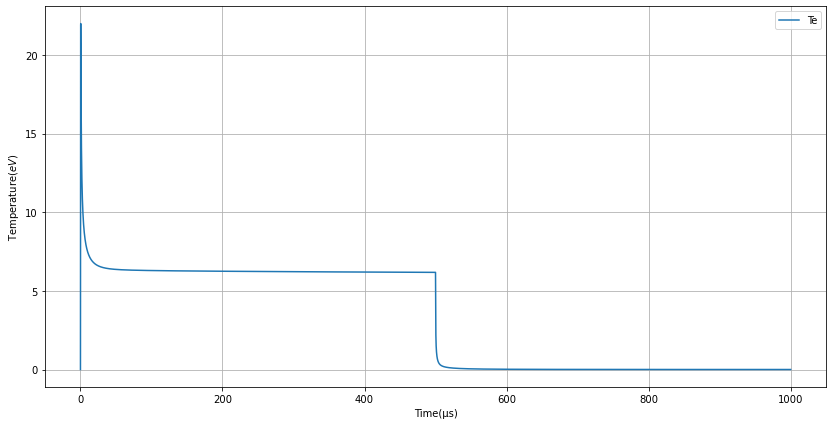

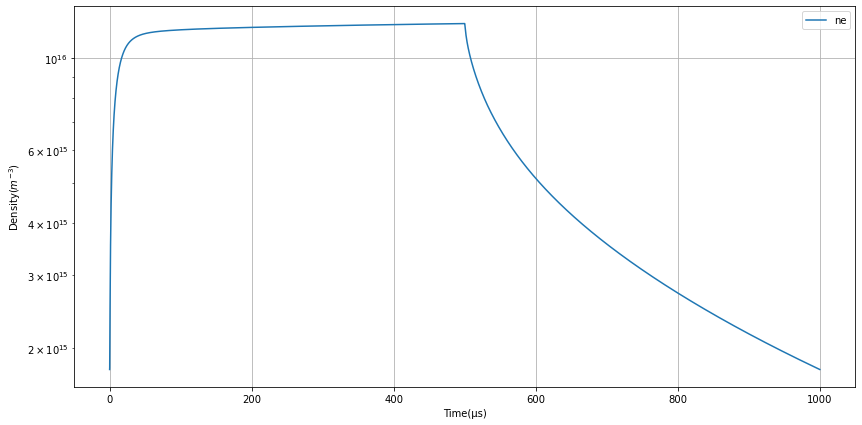

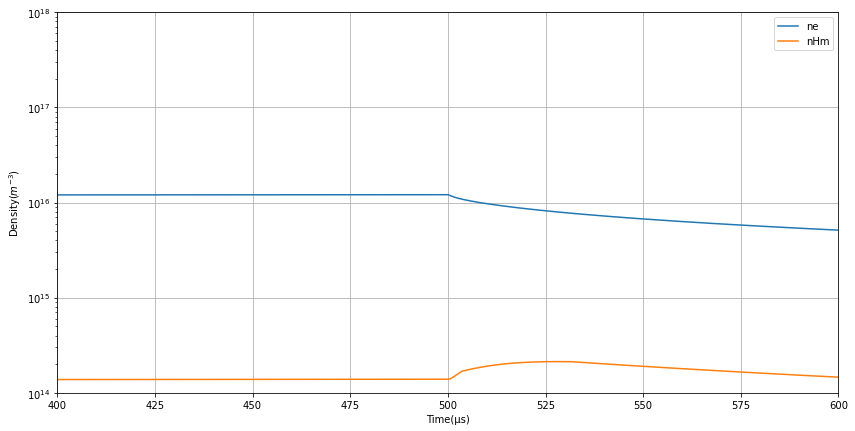

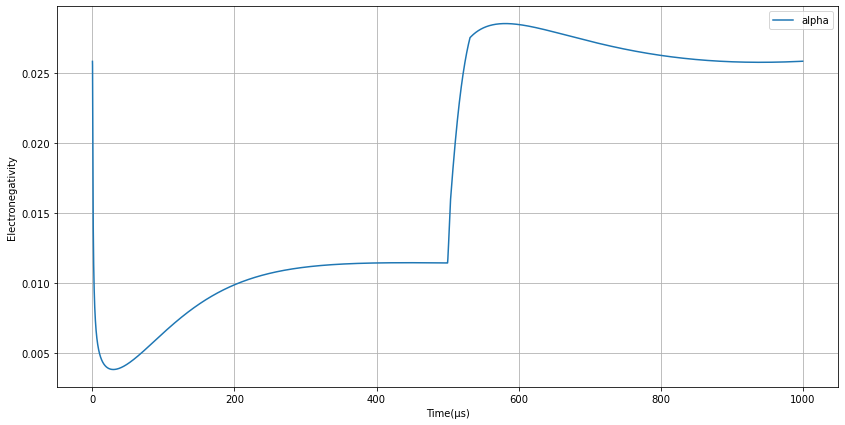

Condition : 10mTorr, 1000.0W, 1.0ms, 1
[2.e+00 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16
 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16 1.e+16]
[[2.00000000e+00 1.00000000e+16 1.00000000e+16 ... 1.00000000e+16
  1.00000000e+16 1.00000000e+16]
 [3.21965408e+00 1.11368290e+16 9.98762123e+15 ... 9.29232782e+15
  1.06065551e+16 9.98311387e+15]
 [3.98039187e+00 1.28062306e+16 1.00042494e+16 ... 8.63541010e+15
  1.11566035e+16 9.96474182e+15]
 ...
 [6.13156852e+00 8.14500223e+18 7.35118654e+16 ... 7.50250192e+14
  8.27009140e+15 1.37514136e+14]
 [6.13156037e+00 8.14523539e+18 7.35118801e+16 ... 7.50248797e+14
  8.27007799e+15 1.37513856e+14]
 [6.13124915e+00 8.14546850e+18 7.35118947e+16 ... 7.50247401e+14
  8.27006458e+15 1.37513577e+14]]
start_iteration
Hm:  1.375136E+14
1
Hm:  1.364828E+14
2
Hm:  136366383276391.03
---------calculation complete!---------
iteration count : 2
---------------------------------------
Running time : 7.344585499999994s


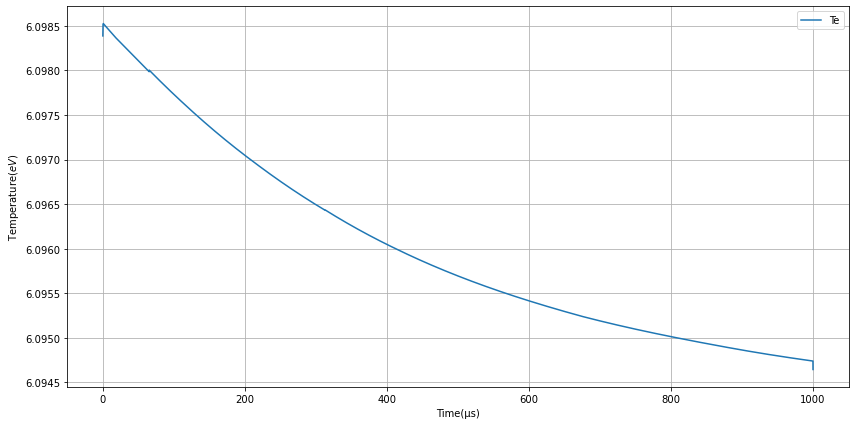

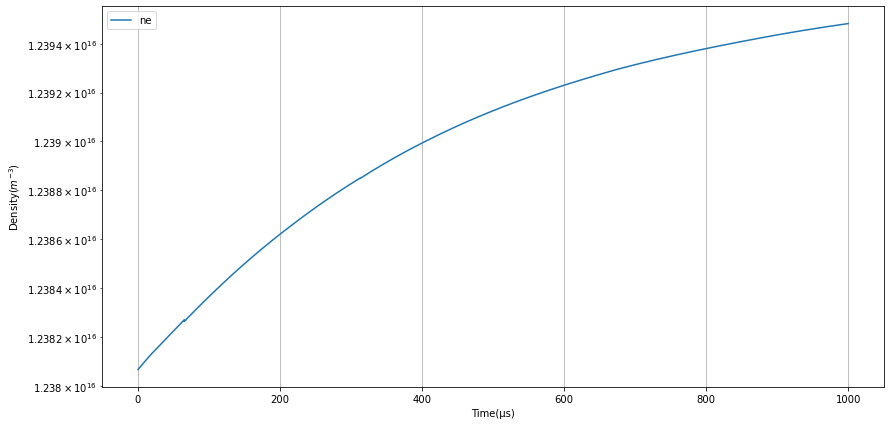

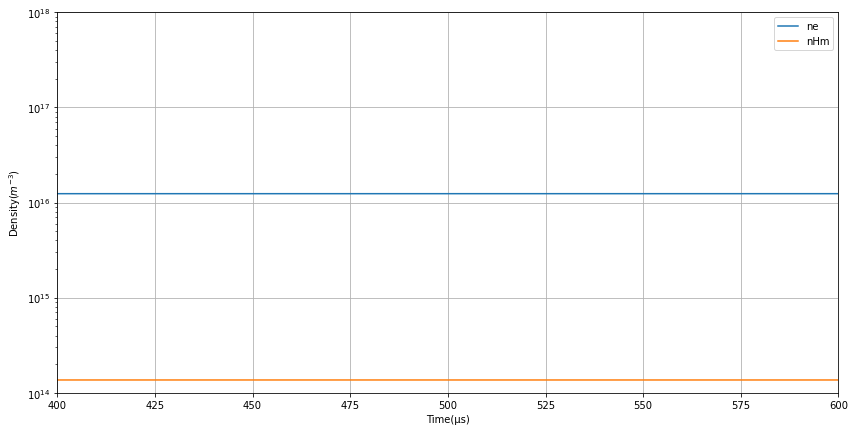

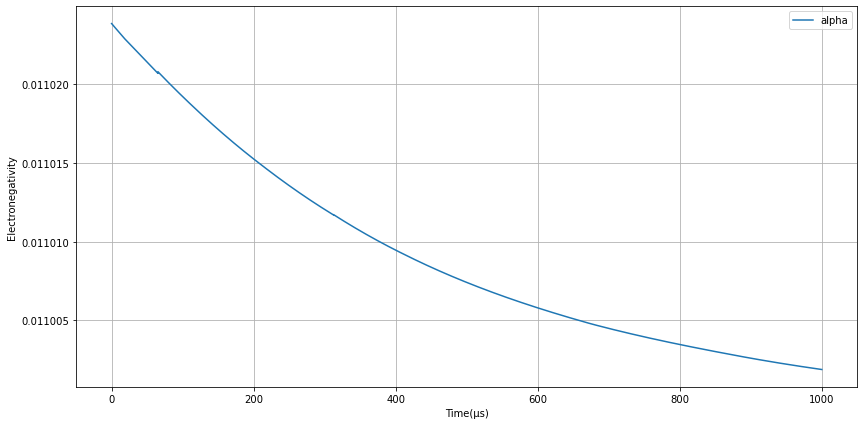

In [21]:
add_path = 'Our_experiment/'
duty_list=[0.5,1]
for duty in duty_list:
    start = timeit.default_timer()
    # [Te, ne, nH, nH_2s, nH2_v0, nH2_v1, nH2_v2, nH2_v3, nH2_v4, nH2_v5, nH2_v6, nH2_v7, nH2_v8, nH2_v9, nHp, nH2p, nH3p, nHm]
    #np.seterr(all='ignore')
    model = Model(10,1000,duty,1e-3,time_resolution=1e-7)
    Model_Result = model.calculation()
    #Result_list = Result_list.append(Model_Result)
    end = timeit.default_timer()
    print('Running time : {}s'.format(end-start))
    graph.result_to_csv(Model_Result, add_path)
    #graph.result_to_csv_select_quick(Model_Result, 'nH2_v0,nH2_v1,nH2_v2,nH2_v3,nH2_v4,nH2_v5,nH2_v6,nH2_v7,nH2_v8,nH2_v9',add_path)
    #graph.result_to_csv_select_quick(Model_Result, 'nHp,nH2p,nH3p',add_path)
    #graph.result_to_csv_select_quick(Model_Result, 'nH,nH_2s,nH2_v0,nH2_v1,nH2_v2',add_path)
    graph.result_to_csv_select_quick(Model_Result, 'Te',add_path)
    graph.result_to_csv_select_quick(Model_Result, 'ne,nHm',add_path)
    graph.plot(Model_Result, 'Te', add_path, file_save = False)
    graph.plot(Model_Result, 'ne', add_path, file_save = False)
    graph.plot(Model_Result, 'ne,nHm', add_path, file_save = False, xlim=(400,600),ylim=(1e14,1e18))
    graph.plot(Model_Result, 'alpha',add_path, file_save = False)
    #graph.plot(Model_Result, 'nHm',add_path, file_save = False)
    #graph.plot(Model_Result, 'ne,nHm,nHp,nH2p,nH3p',add_path, file_save = False)
    #graph.plot(Model_Result, 'nH2_v0,nH2_v1,nH2_v2,nH2_v3,nH2_v4,nH2_v5,nH2_v6,nH2_v7,nH2_v8,nH2_v9',add_path, file_save = False)
    #graph.plot(Model_Result, 'nH2_v0,nH2_v1,nH2_v2,nH,nH_2s',add_path, file_save = False)